In [55]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from packet_utils import compute_crc, ble_whitening, generate_access_code_ble

# payload -> packet (bytes)(whitened) DONE
# bytes -> bits DONE
# bits -> IQ

# Payload -> packet (bytes, whitened)

In [56]:
def create_packet(payload: np.ndarray, base_address: int) -> np.ndarray:
    """
    Create a physical BLE packet from payload and base address.

    Packet Structure:
    ┌───────────┬──────────────┬───────────────┬───────────┬────────┬────────┬─────────┐
    │ Preamble  │ Base Address │ Prefix (0x00) │ S0 (0x00) │ Length │ PDU    │ CRC     │
    ├───────────┼──────────────┼───────────────┼───────────┼────────┼────────┼─────────┤
    │ 0xAA/0x55 │ 4 bytes      │ 1 byte        │ 1 byte    │ 1 byte │ 0–255B │ 3 bytes │
    └───────────┴──────────────┴───────────────┴───────────┴────────┴────────┴─────────┘
    """
    # Set the preamble based on the LSB of the base address
    preamble = np.uint8(0x55 if (base_address & 0x01) else 0xAA)

    # Convert base address into 4 bytes in little-endian order
    base_addr_len = 4
    base_addr_bytes = np.array(
        [np.uint8((base_address >> (i * 8)) & 0xFF) for i in range(base_addr_len)],
        dtype=np.uint8,
    )

    # Set prefix, S0 and length bytes
    prefix = np.uint8(0x00)
    s0 = np.uint8(0x00)
    length = np.uint8(len(payload))

    # Append CRC
    ready_for_crc = np.concatenate(([s0, length], payload))
    crc = compute_crc(ready_for_crc, crc_init=0x00FFFF, crc_poly=0x00065B, crc_size=3)
    ready_for_whitening = np.concatenate((ready_for_crc, crc))

    # Whiten from S0 to CRC
    whitened, _ = ble_whitening(ready_for_whitening)
    packet = np.concatenate(([preamble], base_addr_bytes, [prefix], whitened))

    return packet


# Example values:
base_address = 0x12345678
payload = np.array([0xAB, 0xCD], dtype=np.uint8)

packet = create_packet(payload, base_address)
print("Packet bytes:")
print([hex(byte) for byte in packet])

Packet bytes:
['0xaa', '0x78', '0x56', '0x34', '0x12', '0x0', '0x40', '0xb0', '0x17', '0xe', '0x70', '0x36', '0x9d']


# Packet bytes -> bits

In [57]:
def unpack_uint8_to_bits(uint8_array: np.ndarray) -> np.ndarray:
    """Unpack an array of bytes (np.uint8) into an array of bits, LSB firt"""
    # Unpack bits from each byte into a matrix where each row is the binary representation
    bits = np.unpackbits(uint8_array).reshape(-1, 8)
    bits = bits[:, ::-1]  # LSB first as sent on air
    return bits.flatten()


unpacked = unpack_uint8_to_bits(packet)
print("Unpacked bits:", unpacked)

print(generate_access_code_ble(base_address=base_address))

Unpacked bits: [0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1
 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 1]
01010101_00011110_01101010_00101100_01001000_00000000


# GFSK modulation (bits -> IQ)

In [58]:
# Arguments
sps: int = 10  # Samples per symbol

# Constant
bt = 0.5  # Gaussian filter bandwidth-bit period product
transmission_rate = 1e6  # BLE 1 Mb/s
fs = transmission_rate * sps  # Sampling rate

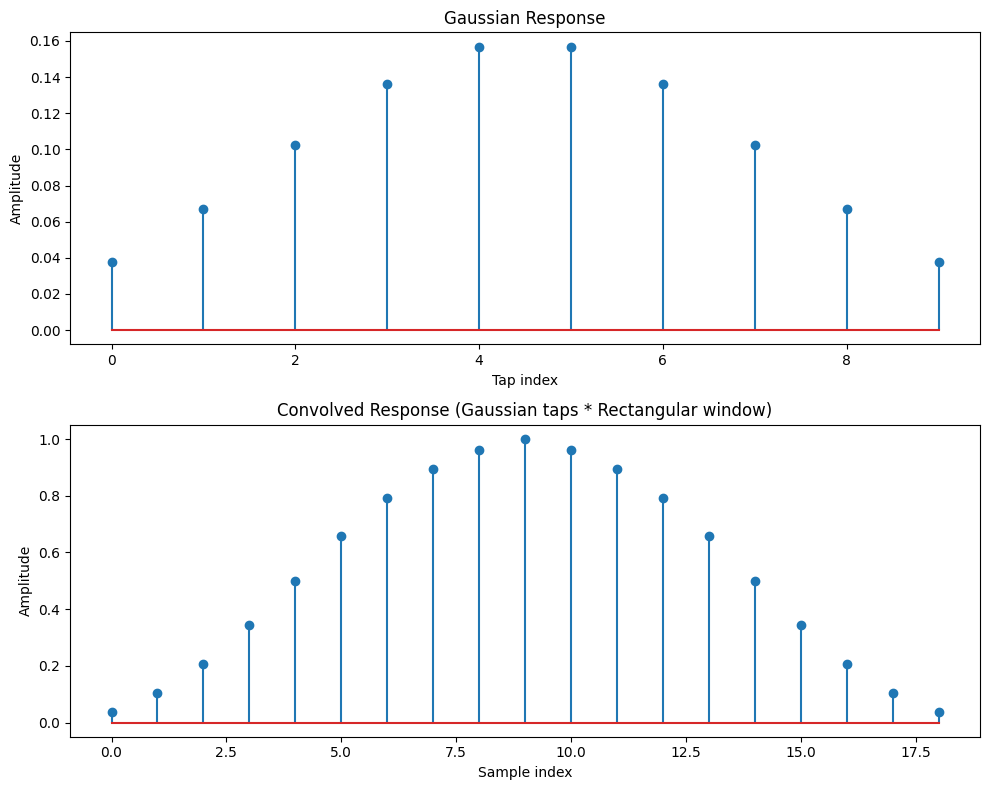

In [59]:
def gaussian_taps(sps: int, ntaps: int, bt: float, gain: float = 1.0) -> np.ndarray:
    """Generate Gaussian FIR filter taps"""
    s = np.sqrt(np.log(2.0)) / (2 * np.pi * bt)  # Scaling factor for time based on BT (bandwidth-bit period product)
    t = np.linspace(-(ntaps - 1) / 2, (ntaps - 1) / 2, ntaps)  # Symmetric time indices around zero
    taps = np.exp(-(t**2) / (2 * (sps * s) ** 2))  # Gaussian function
    return gain * taps / np.sum(taps)  # Normalise and apply gain


# -------------------------
# Set parameters
sps = 10  # Samples per symbol
bt = 0.5  # Bandwidth-bit period product (BLE PHY specification)
transmission_rate = 1e6  # BLE 1 Mb/s
fs = transmission_rate * sps  # Sampling rate
ntaps = sps  # Number of FIR taps

rect_window = np.ones(sps)  # Rectangular window

# -------------------------
# Generate Gaussian taps and convolve with rectangular window
gauss_response = gaussian_taps(sps, ntaps, bt)
convolved_response = scipy.signal.convolve(gauss_response, rect_window)

# -------------------------
# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 1. Plot Gaussian taps
axs[0].stem(gauss_response)
axs[0].set_title("Gaussian Response")
axs[0].set_xlabel("Tap index")
axs[0].set_ylabel("Amplitude")

# 3. Plot the convolved response
axs[1].stem(convolved_response)
axs[1].set_title("Convolved Response (Gaussian taps * Rectangular window)")
axs[1].set_xlabel("Sample index")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

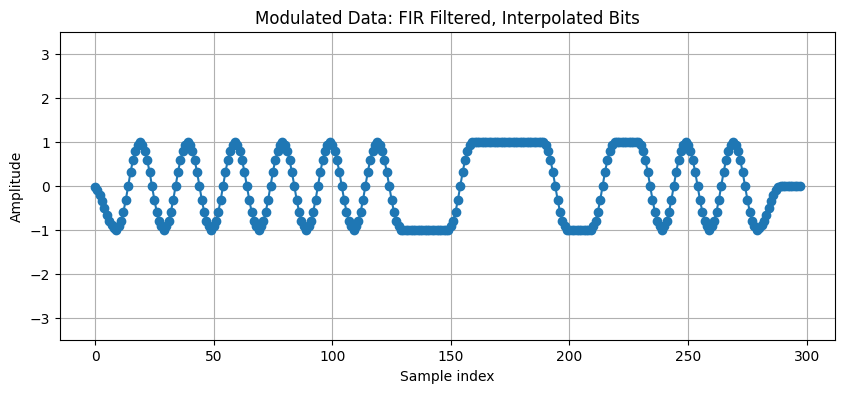

In [60]:
def modulate_bits_fir(bits, sps, fir_taps) -> np.ndarray:
    """Modulates a bit sequence by
    1. Upsampling according to samples per symbol (sps).
    2. Filtering with an FIR filter defined by the FIR taps (fir_taps).
    """
    # Upsample
    upsampled_bits = np.zeros(len(bits) * sps)
    upsampled_bits[::sps] = bits * 2 - 1  # (-1 to 1)

    # Apply FIR filtering
    return scipy.signal.convolve(upsampled_bits, fir_taps, mode="full")


# Create a test bit sequence
bits = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0])

# Use the modulate_bits function to get the filtered (modulated) data.
# modulated_data = modulate_bits_fir(bits, sps, gauss_response)
modulated_data = modulate_bits_fir(bits, sps, convolved_response)


# -------------------------
# Plot the modulated data
plt.figure(figsize=(10, 4))
plt.plot(modulated_data, marker="o", linestyle="-")
plt.title("Modulated Data: FIR Filtered, Interpolated Bits")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.ylim((-3.5, 3.5))
plt.grid(True)
plt.show()